## **GANs**

1. Implement a simple GAN architecture to generate random images (like noise or basic shapes) using
TensorFlow/Keras

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28 * 28, activation='sigmoid'))  # Output size of 28x28 grayscale image
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Define discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator weights during generator training
    model = models.Sequential([generator, discriminator])
    return model

def train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size):
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]
        fake_images = generator.predict(np.random.normal(0, 1, (half_batch, latent_dim)))

        # Real images labeled as 1, fake images labeled as 0
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))  # Real labels = 1
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))  # Fake labels = 0
        d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])  # Use only the loss part of the tuple

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Labels are 1 because we want to fool the discriminator

        # Print progress
        if epoch % 100 == 0:
            # Check if the loss is a list or array and extract the scalar value
            print(f"Epoch {epoch + 1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss[0]:.4f}")
            plot_generated_images(generator, latent_dim, epoch)

# Helper function to plot generated images
def plot_generated_images(generator, latent_dim, epoch, examples=10):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 2))
    for i in range(examples):
        plt.subplot(1, examples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch + 1}")
    plt.show()

# Parameters
latent_dim = 100
epochs = 1000
batch_size = 64

# Build and compile models
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Train GAN
train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


KeyboardInterrupt: 

 2. Implement the discriminator for a GAN with an image input of shape (28, 28)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_discriminator(image_shape=(28, 28, 1)):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Second convolutional layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Third convolutional layer
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Fourth convolutional layer
    model.add(layers.Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Flatten and Dense layer to output a single probability (real or fake)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  metrics=['accuracy'])

    return model

# Build the discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,555,713 (5.93 MB)

 Trainable params: 1,553,793 (5.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

 3. Train the generator to produce simple digits (using noise as input) and plot the generated images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
0 [D loss: 0.6951 | D accuracy: 50.00%] [G loss: 0.6977]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


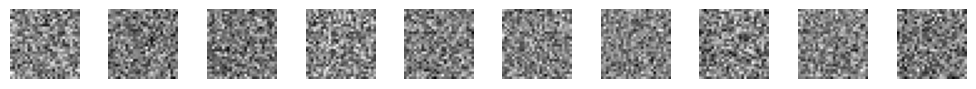

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Build the Generator
def build_generator(latent_dim):
    model = models.Sequential()

    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(np.prod((28, 28, 1)), activation='tanh'))  # tanh to match [-1, 1] range
    model.add(layers.Reshape((28, 28, 1)))

    return model

# Build the Discriminator
def build_discriminator(image_shape=(28, 28, 1)):
    model = models.Sequential()

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output (real or fake)

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

# Build the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during generator training

    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

# Load and preprocess MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension (28, 28, 1)

# Plot generated images
def plot_generated_images(generator, latent_dim, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_image_epoch_{epoch}.png")  # Save image for each epoch
    plt.show()

# Training the GAN
def train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size, sample_interval):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Select a random half-batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half-batch of fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)

        # Train the discriminator (real images = 1, fake images = 0)
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])  # Access the loss part of the tuple

        # Train the generator (wants discriminator to classify fake images as real)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # We want the generator to fool the discriminator

        # Print the progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss:.4f} | D accuracy: {100 * d_loss_real[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")
            plot_generated_images(generator, latent_dim, epoch)

# Main function to run the GAN
def main():
    latent_dim = 100  # Dimension of the noise input
    epochs = 10000
    batch_size = 64
    sample_interval = 1000  # Interval to print the progress and generate images

    # Build and compile the discriminator
    discriminator = build_discriminator()

    # Build the generator
    generator = build_generator(latent_dim)

    # Build the GAN
    gan = build_gan(generator, discriminator)

    # Compile the GAN (this is where we were missing the compile step)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

    # Train the GAN
    train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size, sample_interval)

# Run the GAN
if __name__ == "__main__":
    main()


4. Implement WGAN by modifying the loss function in the GAN

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Build the Generator
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod((28, 28, 1)), activation='tanh'))  # t-sigmoid or tanh works
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Build the Critic (Discriminator in WGAN)
def build_critic(image_shape=(28, 28, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=image_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No sigmoid activation for WGAN
    return model

# Build the WGAN (Generator + Critic)
def build_wgan(generator, critic):
    critic.trainable = False  # Freeze the critic during generator training
    model = models.Sequential([generator, critic])
    return model

# Load and preprocess MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

# Clip critic weights
def clip_critic_weights(critic, clip_value=0.01):
    for layer in critic.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()
            weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            layer.set_weights(weights)

# Plot generated images
def plot_generated_images(generator, latent_dim, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.show()

# Training the WGAN
def train_wgan(generator, critic, wgan, latent_dim, epochs, batch_size, sample_interval, n_critic=5):
    critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)
    generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)

    for epoch in range(epochs):
        for _ in range(n_critic):  # Train critic for 'n_critic' times per generator update
            # Train the critic
            with tf.GradientTape() as critic_tape:
                # Real images
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                real_images = x_train[idx]
                # Fake images
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                fake_images = generator(noise)
                # Critic outputs
                critic_real_output = critic(real_images)
                critic_fake_output = critic(fake_images)
                # Critic loss (Wasserstein distance)
                critic_loss = -tf.reduce_mean(critic_real_output) + tf.reduce_mean(critic_fake_output)

            # Apply gradients to the critic
            critic_gradients = critic_tape.gradient(critic_loss, critic.trainable_variables)
            print(f"Critic Gradients: {len(critic_gradients)}")  # Debugging: print the number of gradients
            critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))

            # Clip critic weights after each critic update
            clip_critic_weights(critic)

        # Train the generator
        with tf.GradientTape() as generator_tape:
            # Generate fake images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator(noise)
            # Generator loss
            generator_loss = -tf.reduce_mean(critic(fake_images))  # We want the critic to believe the fake images are real

        # Apply gradients to the generator
        generator_gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)
        print(f"Generator Gradients: {len(generator_gradients)}")  # Debugging: print the number of gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

        # Print the progress and plot generated images
        if epoch % sample_interval == 0:
            print(f"{epoch} [Critic loss: {critic_loss.numpy():.4f}] [Generator loss: {generator_loss.numpy():.4f}]")
            plot_generated_images(generator, latent_dim, epoch)

# Main function to run the WGAN
def main():
    latent_dim = 100
    epochs = 20000  # Increased epochs for better training
    batch_size = 64
    sample_interval = 1000

    # Build and compile the critic and generator
    critic = build_critic()
    generator = build_generator(latent_dim)

    # Build the WGAN
    wgan = build_wgan(generator, critic)

    # Train the WGAN
    train_wgan(generator, critic, wgan, latent_dim, epochs, batch_size, sample_interval)

# Run the WGAN
if __name__ == "__main__":
    main()


Critic Gradients: 0


ValueError: not enough values to unpack (expected 2, got 0)